# 1. 문제정의

질문1 : 어떤 요소가 앱의 점수에 큰 영향을 주는가?

질문2 : 점수가 높은 앱의 특징은 무엇이고 점수가 낮은 앱의 특징은 무엇인가?

# 2. 방법론

## 2.1. 분석과정

이 질문에 대한 해답을 얻기 위해 아래와 '해석 가능한 머신러닝(xAI)'를 활용한다.

### 2.1.1. 프로세스

1단계 : 데이터 전처리와 EDA를 실시한다.<br>
2단계 : 머신러닝 모델을 만든다.<br>
3단계 : shap value를 통해 어떤 변수가 점수에 가장 큰 영향을 주는지 알아본다.<br>
4단계 : 점수가 높은 앱의 특징과 낮은 앱의 특징을 살펴본다.<br>
5단계 : 최종적으로 앱의 점수를 높이기 위한 방안들을 제시한다.

## 2.1. 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
os.chdir(r'C:\Users\hjb38\Documents\데이터 분석 과정\data\googleplaystore_data')

In [3]:
data = pd.read_csv('googleplaystore.csv')

In [4]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## 2.2. 데이터 전처리 & EDA

### 2.2.1. 결측치 제거

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [6]:
data = data.dropna(axis=0, how='any')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             9360 non-null   object 
 1   Category        9360 non-null   object 
 2   Rating          9360 non-null   float64
 3   Reviews         9360 non-null   object 
 4   Size            9360 non-null   object 
 5   Installs        9360 non-null   object 
 6   Type            9360 non-null   object 
 7   Price           9360 non-null   object 
 8   Content Rating  9360 non-null   object 
 9   Genres          9360 non-null   object 
 10  Last Updated    9360 non-null   object 
 11  Current Ver     9360 non-null   object 
 12  Android Ver     9360 non-null   object 
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


### 2.2.2. Rating(점수) - 타겟값

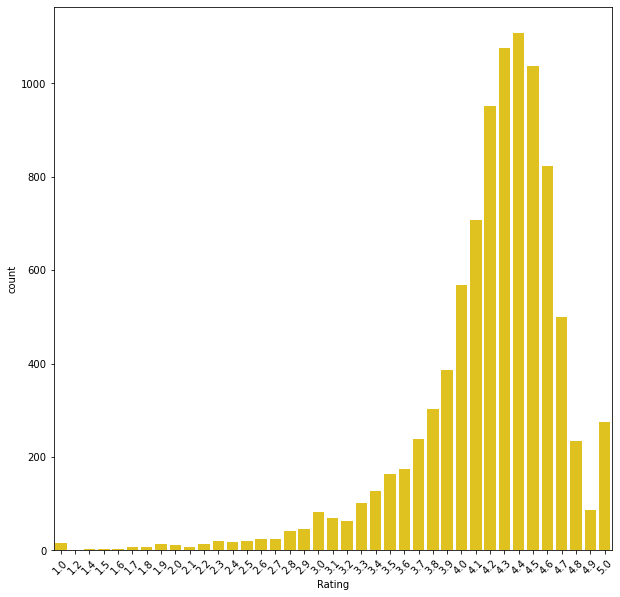

In [8]:
fig, ax1 = plt.subplots(figsize=(10,10))
sns.countplot(data=data, x='Rating', ax=ax1, color='gold')
ax1.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in ax1.get_xticklabels()])
ax1.xaxis.set_tick_params(rotation=45)

In [9]:
data['Rating'].describe()

count    9360.000000
mean        4.191838
std         0.515263
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

- Rating은 대부분 4.1 ~ 4.6 점에 분포해있다.
- 평균 Rating은 4.19 점이다.

### 2.2.3. Category(카테고리)

Text(0.5, 1.0, 'count of Category')

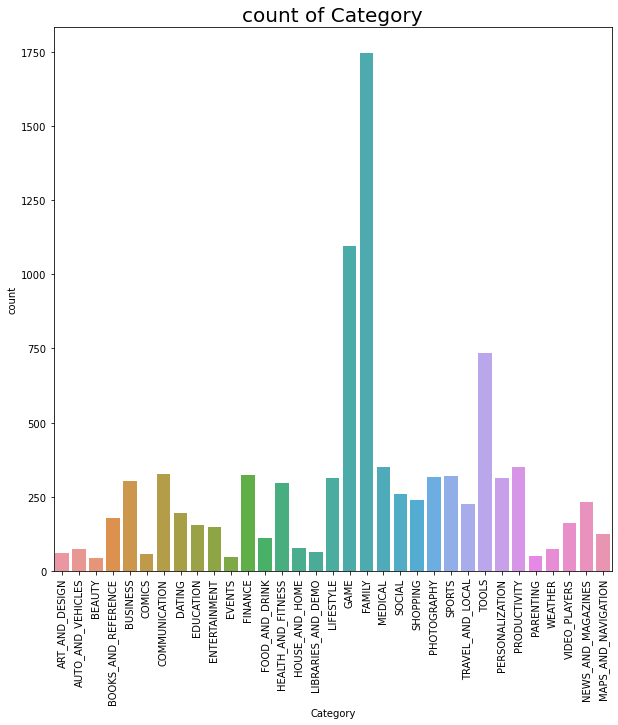

In [10]:
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.countplot(x='Category', data=data)
plt.xticks(rotation=90)
plt.title('count of Category', size=20)

Category 중 가장 수가 많은 3가지는 다음과 같다.
- FAMILY
- GAME
- TOOLS

Text(0.5, 1.0, 'Rating  vs  Category')

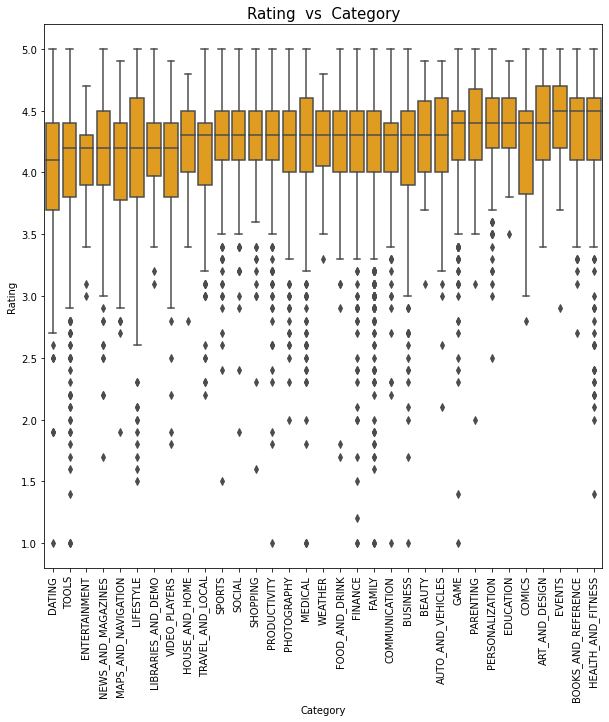

In [11]:
plt.figure(figsize = (10, 10))
result = data.groupby(["Category"])['Rating'].aggregate(np.median).reset_index().sort_values('Rating')
sns.boxplot(x = 'Category', y = 'Rating', data=data, color='orange', order=result['Category'])
plt.xticks(rotation=90)
plt.title('Rating  vs  Category', size=15)

평균 Rating이 높은 Category 3가지는 다음과 같다.
- HEALTH_AND_FITNESS
- BOOKS_AND_REFERENCE
- EVENTS

### 2.2.4. Reviews(리뷰)를 int형으로 변환

In [12]:
# Reviews 는 1개의 데이터 때문에 object형으로 분류됐지만,
# 결측치로 제거하는 과정에서 없어졌기에 int형으로 변경할 수 있다.
data['Reviews'] = data['Reviews'].astype(int)

In [13]:
data['Reviews'].sort_values()

2459            1
8888            1
10529           1
8335            1
8325            1
           ...   
3904     69109672
336      69119316
381      69119316
3943     78128208
2544     78158306
Name: Reviews, Length: 9360, dtype: int32

Text(0.5, 1.0, 'Reviews  vs  Rating')

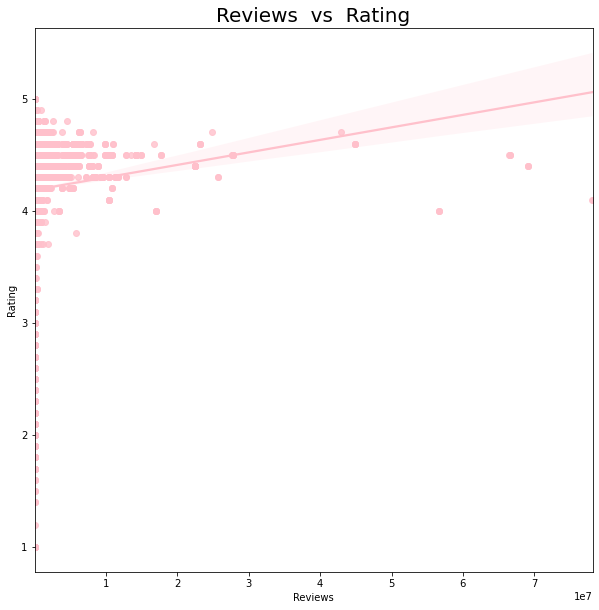

In [14]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", data=data, color='pink')
plt.title('Reviews  vs  Rating', size=20)

Reviews 는 Rating과 양의 상관관계를 가진다.

### 2.2.5. Size(앱 용량)를 int형으로 변환

In [15]:
# data['Size']의 값들 확인
data['Size'].tail(10)

10828                   13M
10829                  7.4M
10830                  2.3M
10832                  582k
10833                  619k
10834                  2.6M
10836                   53M
10837                  3.6M
10839    Varies with device
10840                   19M
Name: Size, dtype: object

In [16]:
# k와 M을 각각 000과 000000으로 바꿔주되, '.'을 없애준다.
def change(x):
    if 'M' in x:
        if '.' in x:
            x = x.replace('.','')
            x = x.replace('M','00000')
            return x
        else:
            x = x.replace('M','000000')
            return x
    elif 'k' in x:
        if '.' in x:
            x = x.replace('.','')
            x = x.replace('k','00')
            return x
        else:
            x = x.replace('k','000')
            return x
    else:
        return x

data['Size'] = data['Size'].apply(change)

In [17]:
data['Size'].tail(10)

10828              13000000
10829               7400000
10830               2300000
10832                582000
10833                619000
10834               2600000
10836              53000000
10837               3600000
10839    Varies with device
10840              19000000
Name: Size, dtype: object

In [18]:
# 'Varies with device'라는 값을 임의로 '0'으로 바꿔준다.
data['Size'] = data['Size'].replace('Varies with device', '0')

In [19]:
data['Size'].tail(10)

10828    13000000
10829     7400000
10830     2300000
10832      582000
10833      619000
10834     2600000
10836    53000000
10837     3600000
10839           0
10840    19000000
Name: Size, dtype: object

In [20]:
# 전체값들을 int형으로 바꿔준다.
data['Size'] = data['Size'].astype(int)

In [21]:
# 임의로 바꾼 0을 NaN 값으로 바꾼다.
data['Size'] = data['Size'].replace(0, np.nan)

In [23]:
# 변환한 NaN을 각 앱의 카테고리별 평균 값으로 대체한다.
data['Size'] = data['Size'].fillna(data.groupby('Category')['Size'].transform('mean'))

Text(0.5, 1.0, 'Size  vs  Rating')

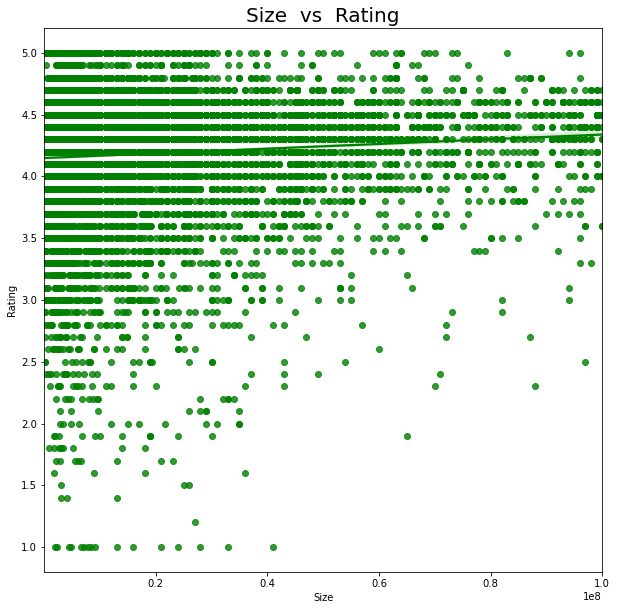

In [24]:
plt.figure(figsize = (10,10))
sns.regplot(x="Size", y="Rating", data=data, color='green')
plt.title('Size  vs  Rating', size=20)

Size는 Rating과 양의 상관관계를 가진다.

In [25]:
data['Size'].value_counts

<bound method IndexOpsMixin.value_counts of 0        19000000.0
1        14000000.0
2         8700000.0
3        25000000.0
4         2800000.0
            ...    
10834     2600000.0
10836    53000000.0
10837     3600000.0
10839    14386250.0
10840    19000000.0
Name: Size, Length: 9360, dtype: float64>

### 2.2.6. Installs(다운로드 횟수)를 int 형으로 변환

In [26]:
data['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '100+', '500+', '10+',
       '5+', '50+', '1+'], dtype=object)

In [27]:
data['Installs'] = data['Installs'].str.replace('+', '')
data['Installs'] = data['Installs'].str.replace(',', '')

In [28]:
data['Installs'] = data['Installs'].astype(int)

In [29]:
data['Installs'].unique()

array([     10000,     500000,    5000000,   50000000,     100000,
            50000,    1000000,   10000000,       5000,  100000000,
       1000000000,       1000,  500000000,        100,        500,
               10,          5,         50,          1])

Text(0.5, 1.0, 'Install  vs  Rating')

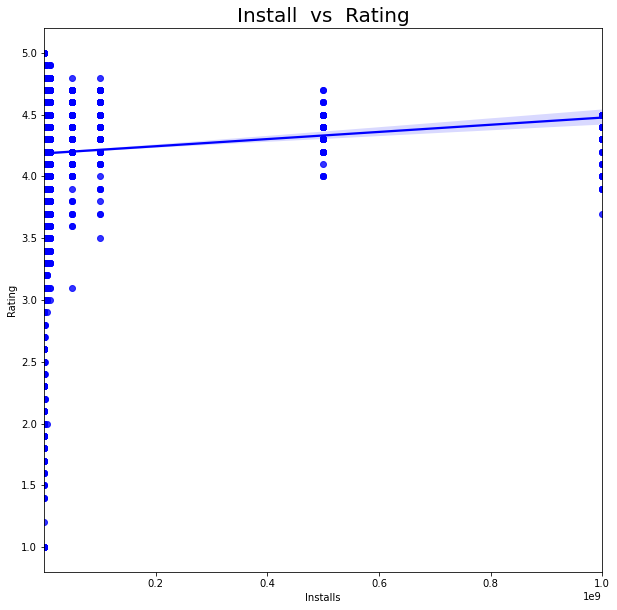

In [30]:
plt.figure(figsize = (10,10))
sns.regplot(x="Installs", y="Rating", data=data, color='blue')
plt.title('Install  vs  Rating', size=20)

Install은 Rating과 양의 상관관계를 가진다.

Text(0.5, 1.0, 'each_Install  vs  Rating')

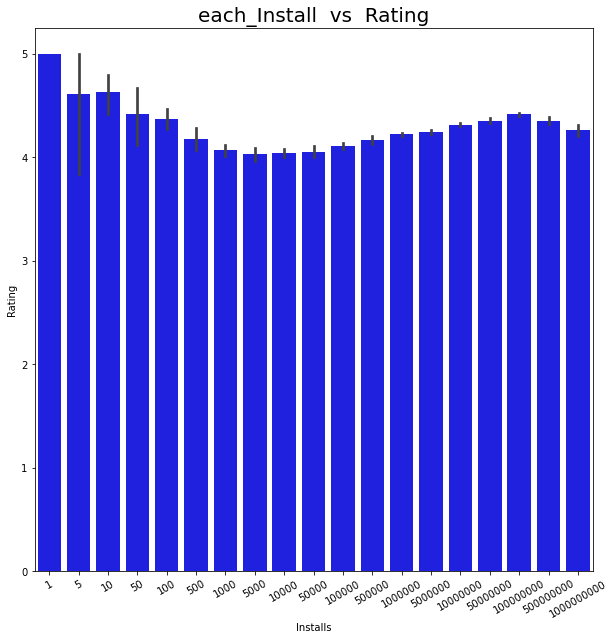

In [31]:
plt.figure(figsize = (10,10))
sns.barplot(x="Installs", y='Rating', data=data, color='blue')
plt.xticks(rotation=30)
plt.title('each_Install  vs  Rating', size=20)

- install 횟수가 50 이하인 것은 표본이 너무 적기에 반영하지 않는다.
- install 횟수가 많을 수록 별점이 높을 것으로 예상했지만 5억을 넘어가면 오히려 낮아진다.

### 2.2.7. Type(유/무료)를 int 형으로 변환

In [32]:
# Type는 Free와 Paid 둘 뿐이므로 각각 0과 1을 부여한다.

# def type_int(types):
#     if types == 'Free':
#         return 0
#     else:
#         return 1
# data['Type'] = data['Type'].map(type_int)

In [33]:
data['Type'].unique()

array(['Free', 'Paid'], dtype=object)

Text(0.5, 1.0, 'Free  vs  Paid  (count)')

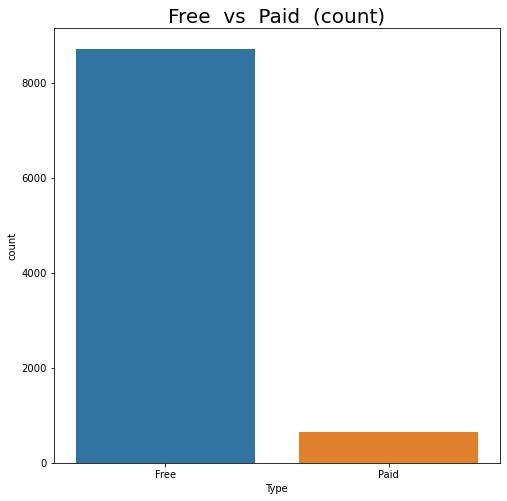

In [34]:
fig, ax = plt.subplots(figsize = (8, 8)) 
sns.countplot(x='Type', data=data)
plt.title('Free  vs  Paid  (count)', size=20)

Text(0.5, 1.0, 'Free  vs  Paid  (Rating)')

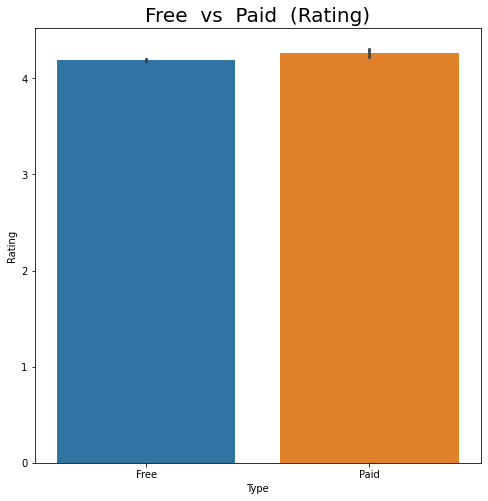

In [35]:
# Free 보다는 Paid가 약간 더 Rating가 높지만 큰 차이는 아니다.
plt.figure(figsize = (8,8))
sns.barplot(x="Type", y="Rating", data=data)
plt.title('Free  vs  Paid  (Rating)', size=20)

Paid(유료)가 약간 더 점수가 높지만, 거의 비슷하다.

### 2.2.8. Price(가격)에서 $빼고 float 형으로 변환, 이상치 제거

In [36]:
data['Price'].value_counts().head()

0        8715
$2.99     114
$0.99     106
$4.99      70
$1.99      59
Name: Price, dtype: int64

In [37]:
data['Price'] = data['Price'].str.replace('$', '')

In [38]:
data['Price'].value_counts().head()

0       8715
2.99     114
0.99     106
4.99      70
1.99      59
Name: Price, dtype: int64

In [39]:
data['Price'] = data['Price'].astype(float)

In [40]:
#가격이 무려 400달러나 되는 앱이 있다.
data['Price'].describe()

count    9360.000000
mean        0.961279
std        15.821640
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       400.000000
Name: Price, dtype: float64

Text(0.5, 1.0, 'distribution of Price')

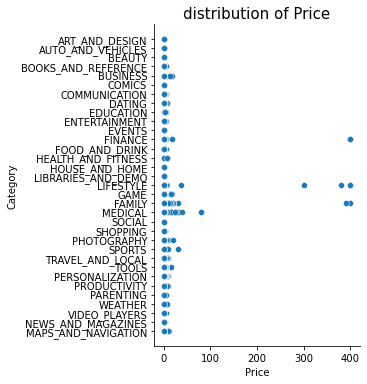

In [41]:
sns.relplot(x="Price", y="Category", data=data)
plt.title('distribution of Price', size=15)

In [42]:
data[data['Price'] > 299]

# 확인해보니  I'm rich 라는 자신의 부유함을 과시하는 앱으로, 아무런 기능도 없는 앱이다.
# 이 앱들은 이번 프로젝트의 방향과는 맞지 않으니 제거해주도록 한다.

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4197,most expensive app (H),FAMILY,4.3,6,1500000.0,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26000000.0,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7300000.0,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
5351,I am rich,LIFESTYLE,3.8,3547,1800000.0,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856,8700000.0,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5355,I am rich VIP,LIFESTYLE,3.8,411,2600000.0,10000,Paid,299.99,Everyone,Lifestyle,"July 21, 2018",1.1.1,4.3 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,4700000.0,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5357,I am extremely Rich,LIFESTYLE,2.9,41,2900000.0,1000,Paid,379.99,Everyone,Lifestyle,"July 1, 2018",1.0,4.0 and up
5358,I am Rich!,FINANCE,3.8,93,22000000.0,1000,Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
5359,I am rich(premium),FINANCE,3.5,472,965000.0,5000,Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up


In [43]:
rich = data[data['Price'] > 299].index
data.drop(rich, inplace=True)

Text(0.5, 1.0, 'New Price')

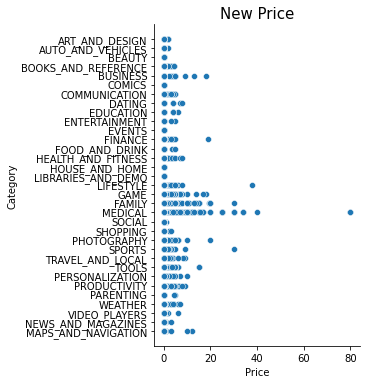

In [44]:
sns.relplot(x="Price", y="Category", data=data)
plt.title('New Price', size=15)

In [45]:
def separate_price(x) :
    if x == 0:
        return '0'
    elif 0<x and x<=1:
        return '0~1'
    elif 1<x and x<=3:
        return '1~3'
    elif 3<x and x<=5:
        return '3~5'
    elif 5<x and x<=10:
        return '5~10'
    elif 10<x and x<=20:
        return '10~20'
    else:
        return '20~'
    
data['separate_Price'] = data['Price'].apply(separate_price)

Text(0.5, 1.0, 'separate_Price  vs  Rating')

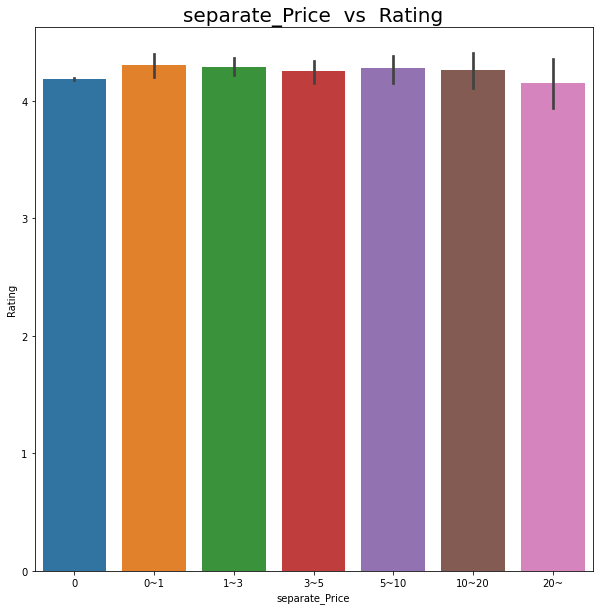

In [46]:
plt.figure(figsize = (10,10))
sns.barplot(x="separate_Price", y="Rating", order=["0", "0~1", "1~3", "3~5", "5~10", "10~20", "20~"], data=data)
plt.title('separate_Price  vs  Rating', size=20)

가격이 무료 ~ 20달러인 App 의 점수는 비슷하지만, 유료 App은 20달러가 넘어가면 점수가 다소 낮아진다.

### 2.2.9. Content Rating(이용등급)

In [47]:
data['Content Rating'].unique()

array(['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+',
       'Adults only 18+', 'Unrated'], dtype=object)

In [48]:
data['Content Rating'].value_counts()

Everyone           7400
Teen               1083
Mature 17+          461
Everyone 10+        397
Adults only 18+       3
Unrated               1
Name: Content Rating, dtype: int64

Text(0.5, 1.0, 'Content Rating')

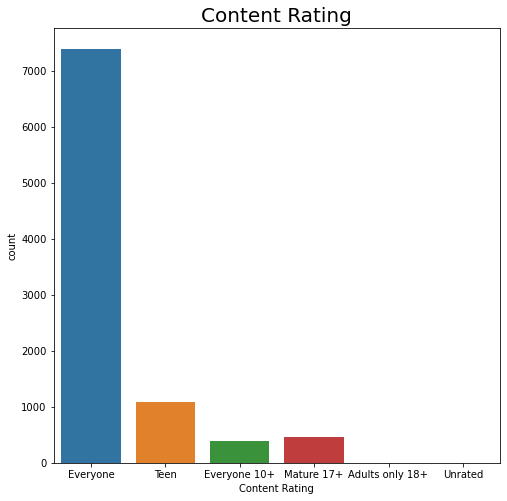

In [49]:
fig, ax = plt.subplots(figsize = (8, 8)) 
sns.countplot(x='Content Rating', data=data)
plt.title('Content Rating', size=20)

콘텐츠 등급은 Everyone이 압도적으로 많다.

In [50]:
data[data['Content Rating'] =='Unrated']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,separate_Price
8266,DC Universe Online Map,TOOLS,4.1,1186,6400000.0,50000,Free,0.0,Unrated,Tools,"February 27, 2012",1.3,2.3.3 and up,0


Text(0.5, 1.0, 'Content Rating')

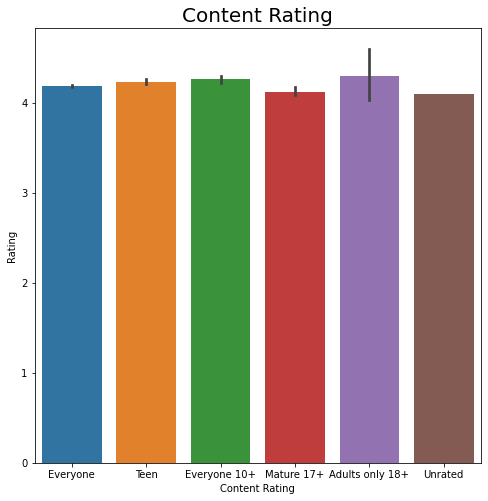

In [51]:
fig, ax = plt.subplots(figsize = (8, 8)) 
sns.barplot(x='Content Rating', y='Rating', data=data)
plt.title('Content Rating', size=20)

콘텐츠 등급별 점수차이는 별로 없지만, Adults only 18+과 Unrated는 표본이 적어서 그대로 반영하기는 어렵다.

### 2.2.10. Genres(세부/중복 카테고리) 간략화

In [52]:
# Genres는 Category의 세부분류이거나 중복 카테고리를 표시한 것이지만,
# Category 대부분이 컬럼과 겹친다.
data['Genres']

0                     Art & Design
1        Art & Design;Pretend Play
2                     Art & Design
3                     Art & Design
4          Art & Design;Creativity
                   ...            
10834                    Education
10836                    Education
10837                    Education
10839            Books & Reference
10840                    Lifestyle
Name: Genres, Length: 9345, dtype: object

In [53]:
# 또한 세부분류를 한 것들은 각각의 수가 너무 적어서 의미있는 데이터라고 보기 어렵다.
data.Genres.value_counts().tail(15)

Health & Fitness;Action & Adventure    1
Tools;Education                        1
Adventure;Brain Games                  1
Parenting;Brain Games                  1
Role Playing;Brain Games               1
Entertainment;Education                1
Strategy;Education                     1
Communication;Creativity               1
Health & Fitness;Education             1
Strategy;Creativity                    1
Lifestyle;Pretend Play                 1
Board;Pretend Play                     1
Music & Audio;Music & Video            1
Puzzle;Education                       1
Card;Brain Games                       1
Name: Genres, dtype: int64

In [54]:
# 따라서 Genres의 값들을 ; 을 기준으로 나눈 뒤 앞의 값들만 사용한다.
data['Genres'] = data['Genres'].str.split(';').str[0]

In [55]:
data['Genres'].unique()

array(['Art & Design', 'Auto & Vehicles', 'Beauty', 'Books & Reference',
       'Business', 'Comics', 'Communication', 'Dating', 'Education',
       'Entertainment', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Adventure', 'Arcade', 'Casual', 'Card', 'Action',
       'Strategy', 'Puzzle', 'Sports', 'Music', 'Word', 'Racing',
       'Simulation', 'Board', 'Trivia', 'Role Playing', 'Educational',
       'Music & Audio', 'Video Players & Editors', 'Medical', 'Social',
       'Shopping', 'Photography', 'Travel & Local', 'Tools',
       'Personalization', 'Productivity', 'Parenting', 'Weather',
       'News & Magazines', 'Maps & Navigation', 'Casino'], dtype=object)

In [56]:
# Music & Audio 은 Music에 포함시키기로 한다.
data.Genres.value_counts().tail(10)

Comics           58
Parenting        50
Card             48
Events           45
Beauty           42
Casino           37
Trivia           28
Word             28
Music            24
Music & Audio     1
Name: Genres, dtype: int64

In [57]:
data['Genres'] = data['Genres'].str.replace('Music & Audio', 'Music')

In [58]:
data.Genres.value_counts().tail(10)

Board        60
Comics       58
Parenting    50
Card         48
Events       45
Beauty       42
Casino       37
Trivia       28
Word         28
Music        25
Name: Genres, dtype: int64

Text(0.5, 1.0, 'Genres  vs  Rating')

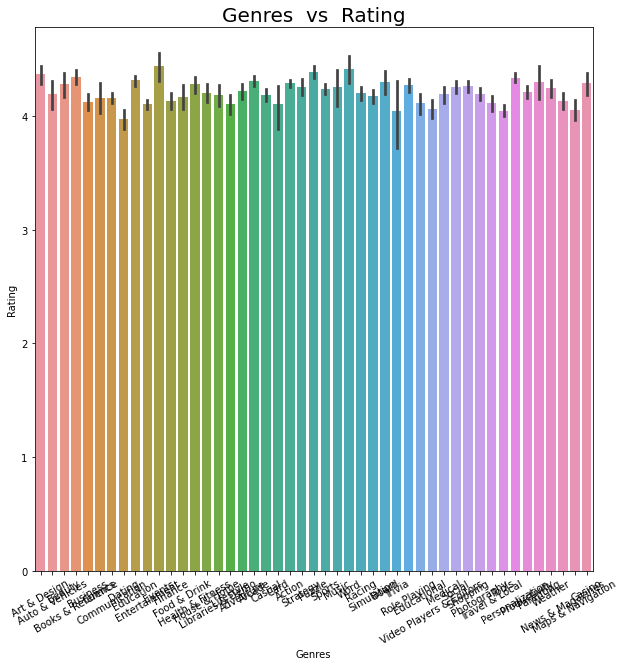

In [59]:
plt.figure(figsize = (10,10))
sns.barplot(x="Genres", y="Rating", data=data)
plt.xticks(rotation=30)
plt.title('Genres  vs  Rating', size=20)

Genres의 종류는 Rating와 큰 상관이 없어 보인다.

### 2.2.11. Last Updated를 int 형으로 변환
Last Updated는 숫자와 문자가 섞여있어서 바로 datetime 형식으로 바꾸는데 어려움이 있다.<br>
따라서 Last Updated 상의 가장 최근 날짜를 현재날짜라 가정하고, 각 데이터의 Last Updated 날짜에서 현재날짜를 뺌으로서 마지막 업데이트를 한 지 몇 일이 지났는지 계산하는 방식을 이용한다.

In [60]:
data['date'] = pd.to_datetime(data['Last Updated'])
data['date'].describe()

count                    9345
unique                   1299
top       2018-08-03 00:00:00
freq                      319
first     2010-05-21 00:00:00
last      2018-08-08 00:00:00
Name: date, dtype: object

In [61]:
data['date'].max()
# 2018-08-03을 현재날짜라고 가정한다.

Timestamp('2018-08-08 00:00:00')

In [62]:
# lastupdate 컬럼을 만들어 계산한 값을 넣는다.
data['lastupdate'] = (data['date'] -  data['date'].max()).dt.days
data['lastupdate'].head()

0   -213
1   -205
2     -7
3    -61
4    -49
Name: lastupdate, dtype: int64

In [63]:
# date는 지워준다.
data = data.drop(labels = ['date'], axis = 1)

# Last Updated도 지운다.
data = data.drop(labels = ['Last Updated'], axis = 1)

Text(0.5, 1.0, 'lastupdate  vs  Rating')

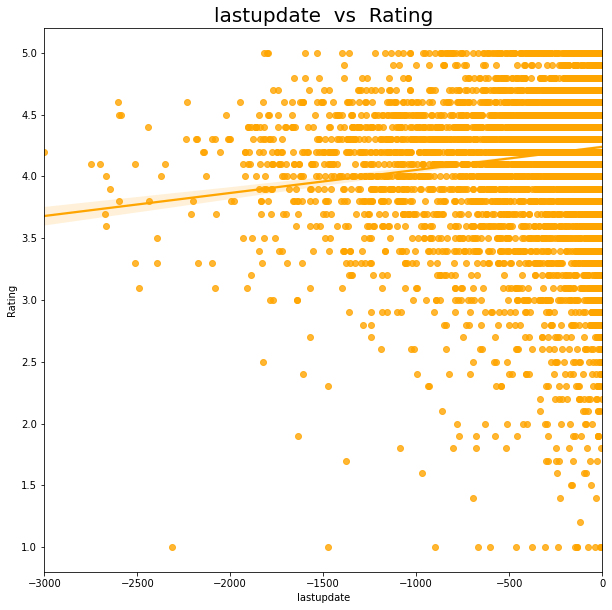

In [64]:
plt.figure(figsize = (10,10))
sns.regplot(x="lastupdate", y="Rating", data=data, color='orange')
plt.title('lastupdate  vs  Rating', size=20)

- lastupdate와 Rating은 양의 상관관게를 갖는다.
- 즉, 최근에 업데이트 했을 수록 Rating이 높다.

### 2.2.12. App, Current Ver, Android Ver 제거

In [65]:
# App은 고유한 이름이기에 데이터로 사용하기에 어려움이 잇음으로 제거
data = data.drop(labels = ['App'], axis = 1)

In [66]:
# Current Ver, Android Ver는 앱마다 버전의 기준이 다르며,
# 'Varies with device' 값을 다른 것으로 대체하기 어렵기 때문에
# 해석에 어려움이 있을 것으로 판단 되어 제거.
data = data.drop(labels = ['Current Ver', 'Android Ver'], axis = 1)

## 2.3. 원핫 인코딩

In [67]:
data.dtypes

Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int32
Type               object
Price             float64
Content Rating     object
Genres             object
separate_Price     object
lastupdate          int64
dtype: object

In [68]:
# Price_detail은 확인했으니 지워준다.
data = data.drop(labels = ['separate_Price'], axis = 1)

In [69]:
data = pd.get_dummies(data, columns = ['Category', 'Type', 'Content Rating', 'Genres'])
data.head()

,Rating,Reviews,Size,Installs,Price,lastupdate,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,...,Genres_Simulation,Genres_Social,Genres_Sports,Genres_Strategy,Genres_Tools,Genres_Travel & Local,Genres_Trivia,Genres_Video Players & Editors,Genres_Weather,Genres_Word
0,4.1,159,19000000.0,10000,0.0,-213,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14000000.0,500000,0.0,-205,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8700000.0,5000000,0.0,-7,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25000000.0,50000000,0.0,-61,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2800000.0,100000,0.0,-49,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2.4. train 과 test 데이터로 나누기

In [70]:
data.info()
# 데이터는 총 9345개

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9345 entries, 0 to 10840
Data columns (total 94 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rating                          9345 non-null   float64
 1   Reviews                         9345 non-null   int32  
 2   Size                            9345 non-null   float64
 3   Installs                        9345 non-null   int32  
 4   Price                           9345 non-null   float64
 5   lastupdate                      9345 non-null   int64  
 6   Category_ART_AND_DESIGN         9345 non-null   uint8  
 7   Category_AUTO_AND_VEHICLES      9345 non-null   uint8  
 8   Category_BEAUTY                 9345 non-null   uint8  
 9   Category_BOOKS_AND_REFERENCE    9345 non-null   uint8  
 10  Category_BUSINESS               9345 non-null   uint8  
 11  Category_COMICS                 9345 non-null   uint8  
 12  Category_COMMUNICATION          9

In [71]:
# 9345개의 데이터 중 8:2 비율로 train, test 데이터를 지정한다.

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=7)

In [72]:
train.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_A

In [73]:
# Rating을 제외한 나머지를 input_var라는 변수에 넣어서 사용

input_var = ['Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Mature 17+',
       'Content Rating_Teen', 'Content Rating_Unrated', 'Genres_Action',
       'Genres_Adventure', 'Genres_Arcade', 'Genres_Art & Design',
       'Genres_Auto & Vehicles', 'Genres_Beauty', 'Genres_Board',
       'Genres_Books & Reference', 'Genres_Business', 'Genres_Card',
       'Genres_Casino', 'Genres_Casual', 'Genres_Comics',
       'Genres_Communication', 'Genres_Dating', 'Genres_Education',
       'Genres_Educational', 'Genres_Entertainment', 'Genres_Events',
       'Genres_Finance', 'Genres_Food & Drink', 'Genres_Health & Fitness',
       'Genres_House & Home', 'Genres_Libraries & Demo', 'Genres_Lifestyle',
       'Genres_Maps & Navigation', 'Genres_Medical', 'Genres_Music',
       'Genres_News & Magazines', 'Genres_Parenting', 'Genres_Personalization',
       'Genres_Photography', 'Genres_Productivity', 'Genres_Puzzle',
       'Genres_Racing', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social', 'Genres_Sports',
       'Genres_Strategy', 'Genres_Tools', 'Genres_Travel & Local',
       'Genres_Trivia', 'Genres_Video Players & Editors', 'Genres_Weather',
       'Genres_Word']

## 2.5. 모델링

### 2.5.1. 상관계수 확인

만약 인풋변수들 끼리 서로 상관성이 높으면 shap value시 모델을 해석하는 데에 어려움이 있을 수 있다.
때문에 모델링 전에 서로 높은 상관성을 띄는 변수들을 제거해준다.

In [74]:
# corr()로 상관계수 확인
corr = train[input_var].corr()

# 시각화
corr.style.background_gradient(cmap='coolwarm')

# 붉은 색일수록 상관계수가 높다.

1차 확인 결과 Category와 Genres 간의 상관계수가 대부분이 1이거나 1에 가까우므로
<br> Genres관련 변수들을 모두 지워주고 다시 살펴본다.

In [75]:
genres = ['Genres_Action',
       'Genres_Adventure', 'Genres_Arcade', 'Genres_Art & Design',
       'Genres_Auto & Vehicles', 'Genres_Beauty', 'Genres_Board',
       'Genres_Books & Reference', 'Genres_Business', 'Genres_Card',
       'Genres_Casino', 'Genres_Casual', 'Genres_Comics',
       'Genres_Communication', 'Genres_Dating', 'Genres_Education',
       'Genres_Educational', 'Genres_Entertainment', 'Genres_Events',
       'Genres_Finance', 'Genres_Food & Drink', 'Genres_Health & Fitness',
       'Genres_House & Home', 'Genres_Libraries & Demo', 'Genres_Lifestyle',
       'Genres_Maps & Navigation', 'Genres_Medical', 'Genres_Music',
       'Genres_News & Magazines', 'Genres_Parenting', 'Genres_Personalization',
       'Genres_Photography', 'Genres_Productivity', 'Genres_Puzzle',
       'Genres_Racing', 'Genres_Role Playing', 'Genres_Shopping',
       'Genres_Simulation', 'Genres_Social', 'Genres_Sports',
       'Genres_Strategy', 'Genres_Tools', 'Genres_Travel & Local',
       'Genres_Trivia', 'Genres_Video Players & Editors', 'Genres_Weather',
       'Genres_Word']

train = train.drop(labels = genres, axis = 1)
test = test.drop(labels = genres, axis = 1)

In [76]:
train.columns

Index(['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_A

In [77]:
input_var = ['Reviews', 'Size', 'Installs', 'Price', 'lastupdate',
       'Category_ART_AND_DESIGN', 'Category_AUTO_AND_VEHICLES',
       'Category_BEAUTY', 'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS',
       'Category_COMICS', 'Category_COMMUNICATION', 'Category_DATING',
       'Category_EDUCATION', 'Category_ENTERTAINMENT', 'Category_EVENTS',
       'Category_FAMILY', 'Category_FINANCE', 'Category_FOOD_AND_DRINK',
       'Category_GAME', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Mature 17+',
       'Content Rating_Teen', 'Content Rating_Unrated']

In [78]:
# corr()로 상관계수 확인
corr = train[input_var].corr()

# 시각화
corr.style.background_gradient(cmap='coolwarm')

,Reviews,Size,Installs,Price,lastupdate,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,Category_BOOKS_AND_REFERENCE,Category_BUSINESS,Category_COMICS,Category_COMMUNICATION,Category_DATING,Category_EDUCATION,Category_ENTERTAINMENT,Category_EVENTS,Category_FAMILY,Category_FINANCE,Category_FOOD_AND_DRINK,Category_GAME,Category_HEALTH_AND_FITNESS,Category_HOUSE_AND_HOME,Category_LIBRARIES_AND_DEMO,Category_LIFESTYLE,Category_MAPS_AND_NAVIGATION,Category_MEDICAL,Category_NEWS_AND_MAGAZINES,Category_PARENTING,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER,Type_Free,Type_Paid,Content Rating_Adults only 18+,Content Rating_Everyone,Content Rating_Everyone 10+,Content Rating_Mature 17+,Content Rating_Teen,Content Rating_Unrated
Reviews,1.000000,0.112638,0.666620,-0.023616,0.087042,-0.012312,-0.012883,-0.010438,-0.016440,-0.025900,-0.010803,0.124806,-0.021962,-0.008794,-0.004898,-0.011190,-0.042052,-0.027433,-0.014557,0.099799,-0.022380,-0.012591,-0.012905,-0.028407,-0.007891,-0.031211,-0.015737,-0.010454,-0.014681,0.005647,-0.013354,-0.004283,0.112226,-0.016458,-0.012262,-0.014605,0.003571,-0.007698,0.041757,-0.041757,-0.001768,-0.082566,0.079493,-0.009054,0.061021,-0.001845
Size,0.112638,1.000000,0.058603,-0.001005,0.214308,-0.036910,-0.010788,-0.028281,-0.044116,-0.059957,-0.032940,-0.086666,-0.029064,-0.020402,-0.002515,-0.021466,0.165932,-0.034090,0.010207,0.387943,0.017810,-0.022110,-0.041346,-0.060469,-0.024598,-0.024486,-0.070120,-0.000863,-0.099376,-0.043652,-0.085484,-0.044599,-0.022692,0.032968,-0.197509,0.018418,-0.041834,-0.037120,0.022038,-0.022038,-0.009412,-0.205986,0.147779,0.036490,0.144207,-0.008615
Installs,0.666620,0.058603,1.000000,-0.029837,0.104350,-0.013947,-0.015634,-0.012552,-0.006589,-0.028781,-0.014341,0.173995,-0.026732,-0.015982,0.005083,-0.013549,-0.062539,-0.030951,-0.018347,0.058281,-0.024490,-0.015149,-0.015394,-0.034305,-0.014196,-0.038419,0.016782,-0.013060,-0.022204,0.026858,0.043859,-0.008295,0.066618,-0.025438,-0.007357,0.019145,0.031506,-0.010989,0.052605,-0.052605,-0.002212,-0.051514,0.032437,-0.016814,0.056791,-0.002270
Price,-0.023616,-0.001005,-0.029837,1.000000,-0.088296,-0.008235,-0.012761,-0.010153,-0.011731,-0.001786,-0.011866,-0.016202,-0.013486,-0.013488,-0.017157,-0.010753,0.014385,-0.016462,-0.012051,-0.016313,-0.015130,-0.013006,-0.012761,-0.005133,-0.008563,0.251434,-0.022739,-0.002264,0.004079,-0.000339,-0.010166,-0.023297,-0.025378,-0.018754,-0.009172,-0.014326,-0.016477,0.007595,-0.566509,0.566509,-0.001764,0.017331,0.009216,-0.007896,-0.022456,-0.001764
lastupdate,0.087042,0.214308,0.104350,-0.088296,1.000000,0.029845,0.031909,0.021076,-0.028037,0.009885,0.029155,0.012260,0.070330,0.020508,0.059403,0.023475,-0.080172,0.051461,0.051140,-0.019429,0.037441,0.002841,-0.049316,-0.030924,0.026358,-0.025206,0.036748,0.022212,-0.091641,0.010962,-0.007433,0.066040,0.041448,0.043081,-0.087889,0.039444,-0.021648,0.009198,0.182429,-0.182429,0.006363,-0.073872,0.021092,0.060130,0.041481,-0.060666
Category_ART_AND_DESIGN,-0.012312,-0.036910,-0.013947,-0.008235,0.029845,1.000000,-0.006867,-0.005464,-0.010873,-0.014553,-0.006385,-0.015669,-0.012212,-0.010301,-0.010480,-0.005787,-0.039924,-0.015669,-0.008955,-0.030203,-0.014847,-0.006999,-0.006867,-0.015545,-0.009159,-0.016156,-0.012852,-0.005628,-0.015388,-0.015168,-0.015792,-0.013604,-0.013847,-0.015357,-0.024041,-0.012998,-0.010700,-0.006934,0.002468,-0.002468,-0.000949,0.025626,-0.009244,-0.018830,-0.013798,-0.000949
Category_AUTO_AND_VEHICLES,-0.012883,-0.010788,-0.015634,-0.012761,0.031909,-0.006867,1.000000,-0.005573,-0.011090,-0.014844,-0.006513,-0.015981,-0.012456,-0.010507,-0.010689,-0.005902,-0.040720,-0.015981,-0.009134,-0.030805,-0.015143,-0.007139,-0.007004,-0.015855,-0.009342,-0.016478,-0.013108,-0.005740,-0.015695,-0.015470,-0.016106,-0.013876,-0.014123,-0.0156

높은 상관성을 띄는 변수는 다음과 같다.

- Installs, Reviews
- Price, Category_MEDICAL
- Price, Type_Paid
- Category_GAME, Size
- Category_DATING, Content Rating_Mature 17+
- Content Rating_Teen, Category_ENTERTAINMENT

각 쌍 중 하나의 변수만 제거해야한다. 그 기준은 타겟값과의 상관계수.<br>
상관계수의 절대값이 더 작은 것을 제거한다.<br>
타겟값 : Raiting

In [79]:
train['Installs'].corr(train['Rating'])

0.05142536218217136

In [80]:
train['Reviews'].corr(train['Rating'])

0.06566664775008912

In [81]:
# Installs 를 제거
del train['Installs']
del test['Installs']

In [82]:
train['Price'].corr(train['Rating'])

0.015867648132407187

In [83]:
train['Category_MEDICAL'].corr(train['Rating'])

-0.0030043164922679663

In [84]:
train['Type_Paid'].corr(train['Rating'])

0.03761069916616932

In [85]:
# Price에 비해 Category_MEDICAL이 타겟값과의 상관은 가장 적으나,
# Price와 Type_Paid를 비교했을 때는 Price를 제거해야 하므로
# Price만 제거하고 Category_MEDICAL은 남겨둔다.
del train['Price']
del test['Price']

In [86]:
train['Category_GAME'].corr(train['Rating'])

0.07213336991097878

In [87]:
train['Size'].corr(train['Rating'])

0.08411079245159475

In [88]:
# Category_GAME 을 제거
del train['Category_GAME']
del test['Category_GAME']

In [89]:
train['Category_DATING'].corr(train['Rating'])

-0.05402437768040562

In [90]:
train['Content Rating_Mature 17+'].corr(train['Rating'])

-0.030320387770681887

In [91]:
# Content Rating_Mature 17+ 을 제거
del train['Content Rating_Mature 17+']
del test['Content Rating_Mature 17+']

In [92]:
train['Content Rating_Teen'].corr(train['Rating'])

0.029455374554924477

In [93]:
train['Category_ENTERTAINMENT'].corr(train['Rating'])

-0.017730569498327946

In [94]:
# Category_ENTERTAINMENT 를 제거
del train['Category_ENTERTAINMENT']
del test['Category_ENTERTAINMENT']

In [95]:
# 인풋변수 다시 지정
train.columns

Index(['Rating', 'Reviews', 'Size', 'lastupdate', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_EVENTS', 'Category_FAMILY', 'Category_FINANCE',
       'Category_FOOD_AND_DRINK', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Ever

In [96]:
input_var = ['Reviews', 'Size', 'lastupdate', 'Category_ART_AND_DESIGN',
       'Category_AUTO_AND_VEHICLES', 'Category_BEAUTY',
       'Category_BOOKS_AND_REFERENCE', 'Category_BUSINESS', 'Category_COMICS',
       'Category_COMMUNICATION', 'Category_DATING', 'Category_EDUCATION',
       'Category_EVENTS', 'Category_FAMILY', 'Category_FINANCE',
       'Category_FOOD_AND_DRINK', 'Category_HEALTH_AND_FITNESS',
       'Category_HOUSE_AND_HOME', 'Category_LIBRARIES_AND_DEMO',
       'Category_LIFESTYLE', 'Category_MAPS_AND_NAVIGATION',
       'Category_MEDICAL', 'Category_NEWS_AND_MAGAZINES', 'Category_PARENTING',
       'Category_PERSONALIZATION', 'Category_PHOTOGRAPHY',
       'Category_PRODUCTIVITY', 'Category_SHOPPING', 'Category_SOCIAL',
       'Category_SPORTS', 'Category_TOOLS', 'Category_TRAVEL_AND_LOCAL',
       'Category_VIDEO_PLAYERS', 'Category_WEATHER', 'Type_Free', 'Type_Paid',
       'Content Rating_Adults only 18+', 'Content Rating_Everyone',
       'Content Rating_Everyone 10+', 'Content Rating_Teen',
       'Content Rating_Unrated']

### 2.5.2 Xgboost

<strong>Xgboost를 사용하는 이유</strong> <br>
: shap value를 활용하기 위해서는 모델이 랜덤포레스트 형태의 tree형 모델이어야 한다. <br>
그 중 Xgboost가 속도가 빠르면서도 높은 성능을 유지하므로 이를 선택했다.

In [97]:
from xgboost import XGBRegressor

In [98]:
model = XGBRegressor(n_estimators=300, learning_rate=0.1)
model.fit(train[input_var], train['Rating'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

###  정확도 확인

In [99]:
from sklearn.metrics import accuracy_score

In [100]:
predictions = model.predict(test[input_var])

In [101]:
# accuracy = accuracy_score(train[input_var], predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [102]:
test['pred'] = predictions
(test['pred'] == test['Rating']).mean()

0.0

## 2.4 shap value 활용

shap value를 활용하면 인풋변수들 중 어떤게 타겟값에 큰 영향을 미치는 알 수 있다.

In [103]:
import shap


In [134]:
explainer = shap.TreeExplainer(model)

In [135]:
shap_values = explainer.shap_values(train[input_var])

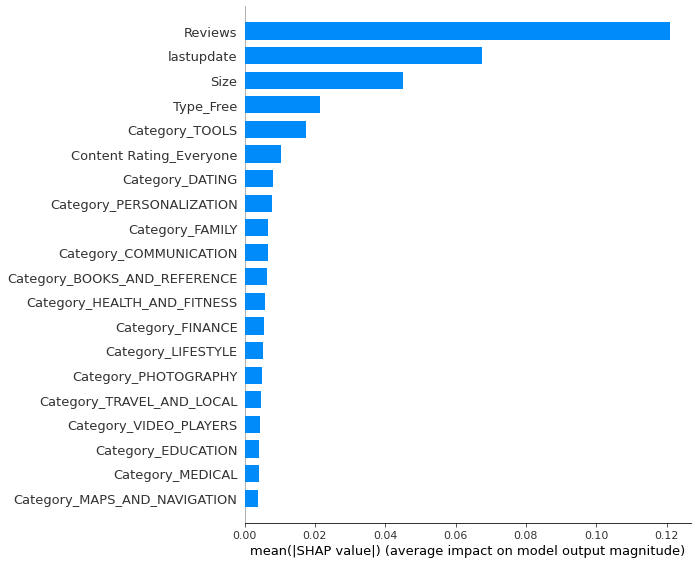

In [104]:
shap.summary_plot(shap_values, train[input_var], plot_type='bar')

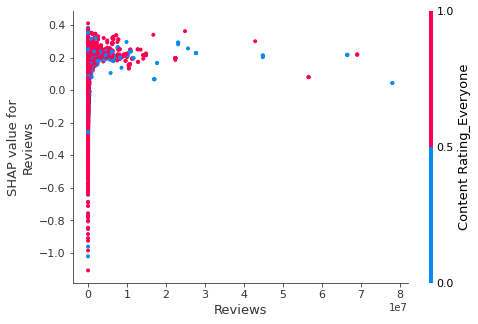

In [112]:
shap.dependence_plot('Reviews', shap_values, train[input_var])

- x값은 1000만 단위로 표시됐다.
- 리뷰 수가 약 100만 이상일 경우 점수에 긍정적인 영향을 주지만, 리뷰가 많을 수록 점수가 더 높아지는 것은 아니다.

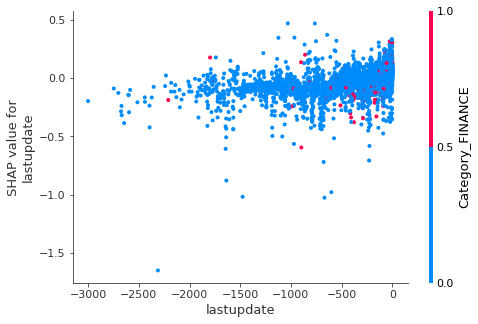

In [106]:
shap.dependence_plot('lastupdate', shap_values, train[input_var])

- x값이 0에 가까울 수록 최근에 업데이트 한 것이다.
- 약 100일 안에 업데이트를 했을 경우 점수에 긍정적인 영향이 더 크지만,
- 100일 이상이 되면 부정적인 영향이 많아지며, 500일이 지나면 부정적인 영향이 앞도적으로 많다.

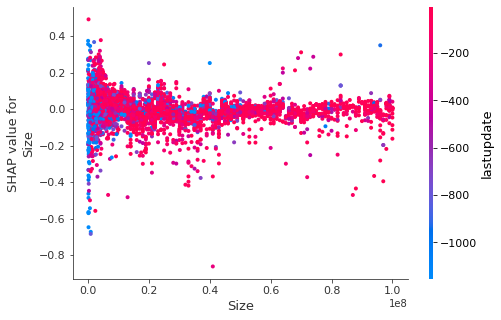

In [107]:
shap.dependence_plot('Size', shap_values, train[input_var])

- x값 0.1은 10M이다.
- EDA단계에서 앱용량이 클수록 점수에 긍정적인 영향을 준 것으로 확인됐지만, shap value를 통해 확인한 결과 반드시 그런것은 아니다.
- 용량이 15M이하일 때 더 높은 점수를 받으며, 그보다 클 때는 점수에 별다른 영향을 주지는 못한다.

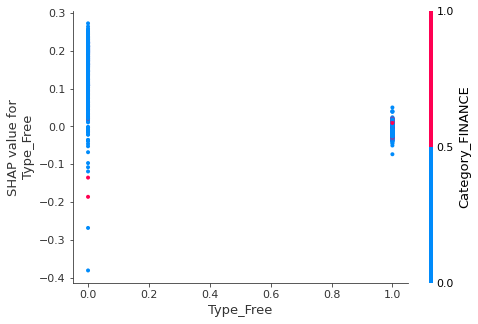

In [108]:
shap.dependence_plot('Type_Free', shap_values, train[input_var])

- x값이 0이면 무료가 아니고(유료), 1이면 무료다.
- 무료보다는 유료앱이 좋은 점수를 받는데 유리함을 알 수 있다. 

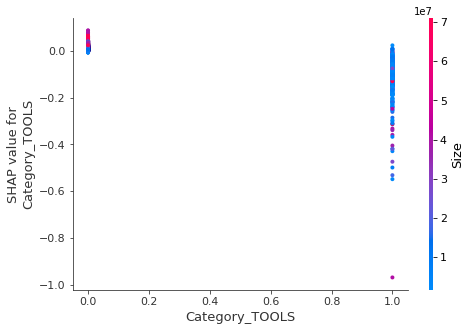

In [109]:
shap.dependence_plot('Category_TOOLS', shap_values, train[input_var])

- x값이 0이면 카테고리가 TOOLS 이외의 것들이고, 1이면 TOOLS이다.
- TOOLS 카테고리의 앱은 좋은 점수를 받지 못한다.